# Discussion 4

In [ ]:
# Taken from Fall 2020 by Can Bakiskan
# Added some comments to explain more clearly

import matplotlib.pyplot as plt
%matplotlib notebook

## Dimensionality Reduction

A few reasons we might do dimensionality reduction:

- When the numer dimensions of data gets high, some (if not most) algorithms have difficulty processing the data due to computational constraints.
- "In order to obtain a statistically sound and reliable result, the amount of data needed to support the result often grows exponentially with the dimensionality." This is called the curse of dimensionality. That means when you don't have enough data with respect to the number of dimensions, your model will most likely overfit for your training data which will hurt generalization.
- Sometimes one needs to convey some information about the data or the model through visualizations and we cannot visualize more than 3 dimensions. For this reason sometimes we need to use dimensionality reduction to bring the number of dimensions to 2 or 3 while preserving the information we're trying to convey.

### Principal Component Analysis

One of the methods of dimensionality reduction is called Principal Component Analysis (PCA). Given a set of data, PCA identifies (orthogonal) directions with highest variance and projects the data onto the first $n$ significant (principal) directions. Let's analyze this using a data distributed in a parallelogram.

(-0.10767096208975135,
 3.073965853253455,
 -0.10281095924943418,
 3.0538684909471416)

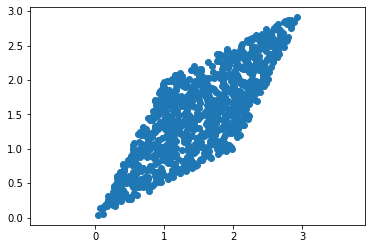

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# seed for reproducibility
np.random.seed(2020)

some_dataset=np.random.rand(1000,2)
shear_matrix=np.array([[1,2],[2,1]])
some_dataset=some_dataset@shear_matrix
fig=plt.figure()
plt.scatter(some_dataset[:,0],some_dataset[:,1])

plt.axis('equal')

PCA identifies the orthogonal directions with highest variance using a matrix decomposition method called singular value decomposition (SVD). When SVD is applied on the data matrix $D_{mxn}$. It decomposes it into three matrices: $U_{mxm}$, $S_{mxn}$ and $V_{nxn}$. $U$ and $V$ are orthogonal matrices (meaning $U^TU=I$ and $V^TV=I$) and $S$ only has nonzero elements in its diagonal entries (if $m\neq n$ you can trim $S$ to be a square matrix and consider the diagonal of that matrix). The decomposition can be written as $D=USV^T$

Basically, $U$ gives an orthonormal basis of $\mathbb{R}^m$ and $V$ gives an orthonormal basis of $\mathbb{R}^n$. The geometric intuition is that if we think $D$ as a linear mapping (of vectors)  $\mathbb{R}^n \rightarrow \mathbb{R}^m$:  $x \rightarrow Dx$, it can be viewed as first writing $x$ in terms of columns of $V$, then multiplying with corresponding value in the diagonal of $S$ and then multiplying with columns of $U$. 

For our purposes we are will only be interested in $V$ and $S$ matrices. $V$'s columns will give the orthogonal directions with highest variance, and diagonal entries of $S$ will give the variances along those directions.

Let's use `np.linalg.svd` to compute these matrices.

27.56630096149316 [-0.72288515 -0.6909682 ]
9.22844662927537 [ 0.6909682  -0.72288515]


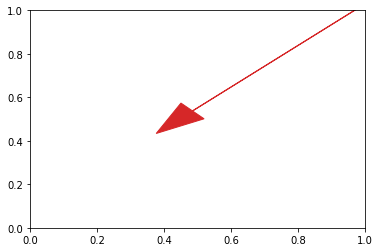

In [ ]:
U,S,V_t=np.linalg.svd(some_dataset-some_dataset.mean(axis=0))

for s,v in zip(S,V_t):
    print(s,v)
    s/=20 # scale by variances but divide by 20 for display purposes
    plt.arrow(*some_dataset.mean(axis=0), s*v[0], s*v[1], color='tab:red',head_width=.1)

If you look at the previous figure, it now displays the orthogonal directions of highest variance. It is no surprise that the directions with highest variance are the diagonals of the parallelogram, as we intuitively guess.

Now the recipe PCA follows in order to reduce the dimensions is this:
1. Centralize the data by subtracting the mean.
2. Find the directions with highest varience using SVD. The directions will be columns of $V$ and variances will be diagonal entries of $S$.
3. Zero out the smallest entries of S until there are $n$ (the desired number of dimensions) nonzero entries.
4. Remultiply $U$, $S_{truncated}$ and $V$ to get $D_{projected}$: $D_{projected}=US_{truncated}V^T$.

Let's do this in the code:

In [ ]:
means=some_dataset.mean(axis=0)

U,S,V_t=np.linalg.svd(some_dataset-means) # subtract the means and do SVD

# S gives only the diagonal entries in a 1d array put those in a matrix
S=np.vstack((np.diag(S),np.zeros((998,2))))

# The first principle component accounts for the highest variance in the dataset
# Then next variance and so on, until p = originalNumFeatures have been calculated
# https://builtin.com/data-science/step-step-explanation-principal-component-analysis

n=1
# zero out all but n largest values of S: 
i=S.shape[1]-1

while i>=n:
    S[i,i]=0.
    i-=1

# add the means back
pca_projection=U@S@V_t+means  # @ overloads matmul for matrix multiplication

Let's display this projection operation:

(0.2707150078816327,
 3.0538228451627507,
 0.3324533092165234,
 2.9926808870873374)

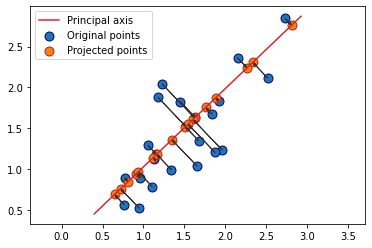

In [ ]:
subset=some_dataset[:20]

plt.figure()

plt.scatter(subset[:,0],subset[:,1],label="Original points", edgecolor="navy", s=80)
plt.plot([means[0]-2*V_t[0,0],means[0]+1.5*V_t[0,0]],[means[1]-2*V_t[0,1],means[1]+1.5*V_t[0,1]], 'tab:red', label="Principal axis")

plt.scatter(pca_projection[:20,0],pca_projection[:20,1], s=80, label="Projected points", facecolor='tab:orange', edgecolor='firebrick')

for original_point,projected_point in zip(subset,pca_projection[:20]):
    plt.arrow(original_point[0], original_point[1], projected_point[0]-original_point[0],\
              projected_point[1]-original_point[1], color=(0.2,0.2,0.2),head_width=.03, length_includes_head=True)

plt.legend()
plt.axis('equal')


Now let's use off-the-shelf PCA estimator given by `sklearn.decomposition.PCA` and see what that shows:

([], <a list of 0 Text major ticklabel objects>)

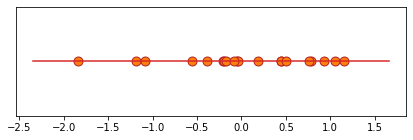

In [ ]:
from sklearn.decomposition import PCA
pca_estimator=PCA(n_components=1)
projected_dataset=pca_estimator.fit_transform(some_dataset)
plt.figure(figsize=(7,2))
plt.scatter(projected_dataset[:20],np.zeros((20)), facecolor="tab:orange", edgecolor='firebrick', s=80)
plt.plot([projected_dataset[:20].min()-0.5,projected_dataset[:20].max()+0.5], [0,0], color="tab:red")
plt.yticks([])


We can see that if you flip the red line in the 2d plot above, the distance between the orange points in that plot and the distances between orange points in this plot match exactly. The reason for the flip is that PCA is orientation agnostic so in some solvers it will give vectors negative of other solvers. And the reason we have a 2d plot above and a 1d plot below is because when manually applying PCA, we kept the ambient number of dimensions which was 2. `sklearn`'s PCA estimator automatically reduces the ambient dimension to $n$.

Now let's do the same thing in 3 dimensions. We will reduce a dataset's number of dimensions from 3 to 2. **This example will also demonstrate an important property of PCA, that is it does not see labels**. In that regard, it is an unsupervised dimensionality reduction method. What I mean by it doesn't see labels is, PCA treats the whole dataset as a single entity and does not treat datapoints from different classes any different.

In [ ]:
N=500
np.random.seed(2020)
X1=np.array([[-0.3,0.1,-0.3],[1.3,0.3,-0.2],[-0.1,0.4,0.5]])
X2=0.5*np.random.randn(3,3)-0.25
setA=np.random.multivariate_normal(mean=[1,1,1], cov=X1.T@X1, size=N//2)
setB=np.random.multivariate_normal(mean=[3,1,2], cov=X2.T@X2, size=N//2)

total_dataset=np.concatenate((setA,setB),axis=0)

print(total_dataset)

[[ 1.66260519  1.21537847  0.22623213]
 [-0.7364769   0.33569853  0.4862596 ]
 [ 2.98291387  1.02686213  0.66245719]
 ...
 [ 2.85897432  1.10788735  1.63873939]
 [ 4.0713945   2.81110915  4.01661919]
 [ 2.83920195  0.78748831  1.79351739]]


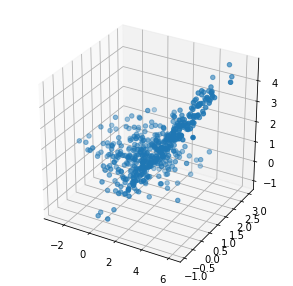

In [ ]:
# this creates a new figure with the given figsize
# .gca stands for get current axes. without calling that with
# projection='3d' matplotlib assumes the plot is 2d
# don't worry too much about this
fig=plt.figure(figsize=(5,5)).gca(projection='3d')

# to demonstrate the agnosticism of PCA to labels, we too will plot different classes with the same color
fig.scatter(total_dataset[:,0],total_dataset[:,1],total_dataset[:,2]);


Reduce the dimensions to 2 using `sklearn.decomposition.PCA`

In [ ]:
from sklearn.decomposition import PCA

pca_estimator=PCA(n_components=2)

reduced_dataset=pca_estimator.fit_transform(total_dataset)
print(total_dataset[:5])
print(reduced_dataset[:5])

[[ 1.66260519  1.21537847  0.22623213]
 [-0.7364769   0.33569853  0.4862596 ]
 [ 2.98291387  1.02686213  0.66245719]
 [ 0.32371675  1.48405955  0.75460025]
 [ 0.98089637  0.83422298  1.06540199]]
[[-0.80666634  0.77289958]
 [-2.97732196 -0.29106665]
 [ 0.50318223  1.11579488]
 [-1.6973622  -0.3875485 ]
 [-1.11751999 -0.10531345]]


Text(0, 0.5, 'Second principal component (direction)')

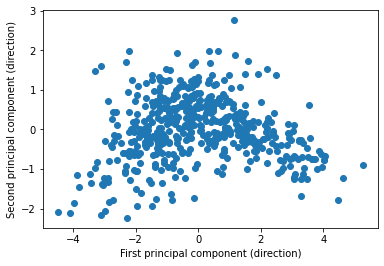

In [ ]:
plt.figure()
plt.scatter(reduced_dataset[:,0],reduced_dataset[:,1])
plt.xlabel("First principal component (direction)")
plt.ylabel("Second principal component (direction)")

If we want to access the directions (columns of $V$ from before) and variances along those directions (diagonal entries of $S$ from before) we can use attributes of `PCA`. Note that we can only access the first $n$ directions and variances.

In [ ]:
print(pca_estimator.components_)
print(pca_estimator.singular_values_)

means=total_dataset.mean(axis=0)
# confirm that svd and pca gives the same directions
U,S,V_t=np.linalg.svd(total_dataset-means)
print(V_t)
print(S)

[[ 0.87747295  0.20294552  0.43457375]
 [ 0.47929099 -0.33716236 -0.81030963]]
[39.80251014 17.84012809]
[[ 0.87747295  0.20294552  0.43457375]
 [ 0.47929099 -0.33716236 -0.81030963]
 [ 0.0179268  -0.91931206  0.39312081]]
[39.80251014 17.84012809 10.08385324]


Confirm that the directions are orthogonal:

In [ ]:
print(pca_estimator.components_[0]@pca_estimator.components_[1])

-5.4009107777407105e-18


We can do visualize the principal components on the 3d scatterplot as well:

[0.7960502  0.35680256]


(-2.9100123825964195, 6.198157472579295)

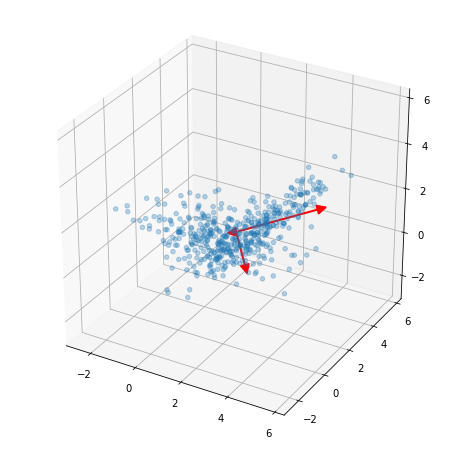

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch


class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

        
scaled_components=np.diag(pca_estimator.singular_values_) @ pca_estimator.components_/50
print(np.linalg.norm(scaled_components,axis=1))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')  
        
# ax.scatter(setA[:,0],setA[:,1],setA[:,2], alpha=0.4);
# ax.scatter(setB[:,0],setB[:,1],setB[:,2], alpha=0.4);
ax.scatter(total_dataset[:,0],total_dataset[:,1],total_dataset[:,2], alpha=0.3);
ax=fig.gca()
means=total_dataset.mean(axis=0)
for s,v in zip(S,V_t):
    scaled_v=s/10*v
    a = Arrow3D([means[0], means[0]+scaled_v[0]], [means[1], means[1]+scaled_v[1]], [means[2],\
                means[2]+scaled_v[2]], mutation_scale=20, lw=2, arrowstyle="-|>", color="r")
    ax.add_artist(a)
    
    
X=total_dataset[:,0]
Y=total_dataset[:,1]
Z=total_dataset[:,2]
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z.max()+Z.min())
# Comment or uncomment following both lines to test the fake bounding box:
for xb, yb, zb in zip(Xb, Yb, Zb):
    ax.plot([xb], [yb], [zb], 'w')  
ax.set_xlim(total_dataset.min(),total_dataset.max())
ax.set_ylim(total_dataset.min(),total_dataset.max())
ax.set_zlim(total_dataset.min(),total_dataset.max())
